# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Условия:

- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.**

## Описание данных:

Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv. 
- geo_data_1.csv. 
- geo_data_2.csv. 

    - id — уникальный идентификатор скважины;
    - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    - product — объём запасов в скважине (тыс. баррелей).

# 1. Загрузка и подготовка данных

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [3]:

from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
 
# Оценка правильности
from sklearn.metrics import accuracy_score
# Разделение на тренировочную и валидационную выборку
from sklearn.model_selection import train_test_split
# Средняя квадратичная ошибка
from sklearn.metrics import mean_squared_error
# Оценка качества модели
from sklearn.metrics import classification_report
# Перебор параметров
from sklearn.model_selection import GridSearchCV
# classifier that makes predictions using simple rules
from sklearn.dummy import DummyClassifier

In [4]:
# Для оформления 
bold_start = '\033[1m'
yellow = '\033[33m'
red = '\033[31m'
violet = '\033[35m'
blue = '\033[34m'
green = '\033[32m'
green_background = '\033[42m'
red_background = '\033[41m'
bold_end   = '\033[0m'

In [5]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

all_data = [data_0, data_1, data_2]

In [6]:
for i in range(0,3):
    print(bold_start+ red_background+ '='*20, 'data_%s' %i, '='*20 +bold_end )
    display(all_data[i].describe())
    
    display(all_data[i].head())
    display(all_data[i].info())
    display(print(bold_start + 'isna:' + bold_end ),all_data[i].isna().sum())
    display(print(bold_start + 'isnull:' + bold_end ),all_data[i].isnull().sum())

==================== data_0 ====================


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

isna:


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

isnull:


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

==================== data_1 ====================


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

isna:


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

isnull:


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

==================== data_2 ====================


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

isna:


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

isnull:


None

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

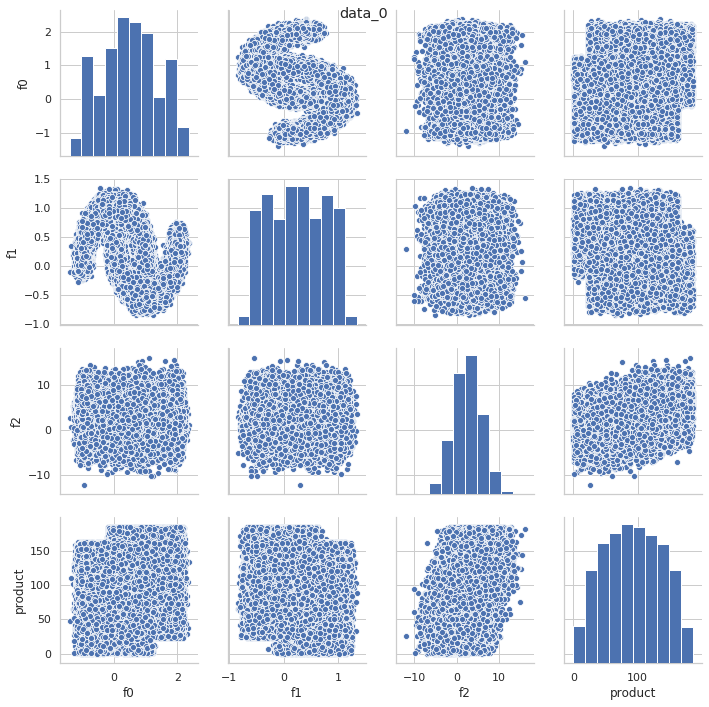

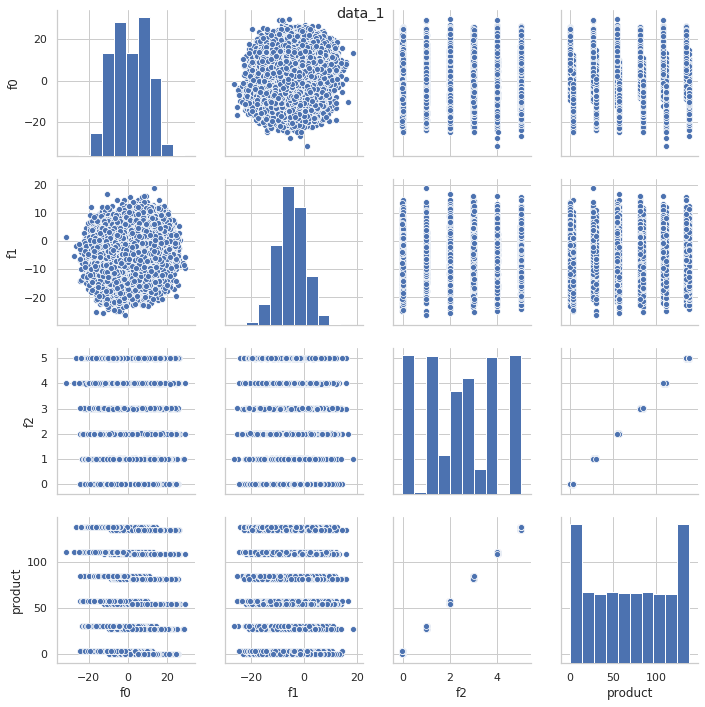

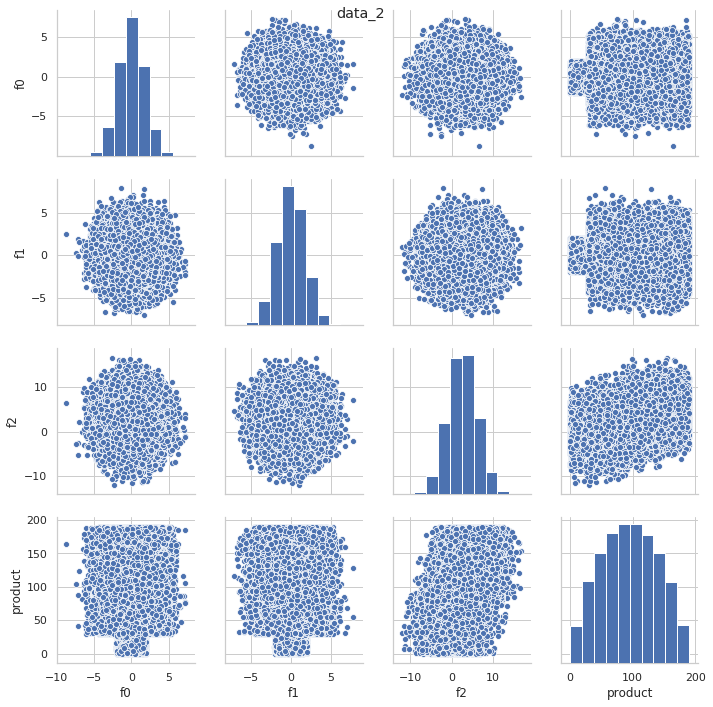

In [7]:
for i in range(0,3):  
    sns.pairplot(all_data[i])
    plt.suptitle('data_%s' %i)

Плохо, что нам не объяснили значения f0, f1, f2.
Поэтому сложно определить их качество.
* В **geo_0** и **geo_2** наблюдается нормальное распределение показателя *product*, который является целевым признаком 
* **geo_1** похвастаться нормальным распределением не может, зато заметна линейная зависимость между *f2* и *product*
* Можно заметить кластеры во вседатасетах

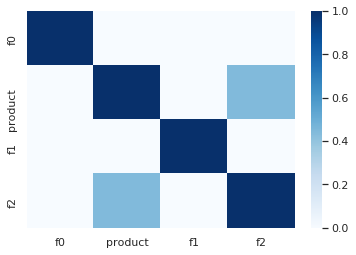

In [8]:
numericalq = list(set(data_1.columns))

# Calculate and plot
corr_matrixq = all_data[i][numericalq].corr()
sns.heatmap(corr_matrixq, cmap="Blues")

#### Проверка на дубликаты:

In [9]:
for i in range(0,3):
    print(bold_start+ red_background+ '='*20, 'data_%s' %i, '='*20 +bold_end)
    
    print('data_%s:'%i, all_data[i]['id'].duplicated().sum())    
    display(all_data[i][all_data[i]['id'].duplicated()==True])

==================== data_0 ====================
data_0: 10


,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


==================== data_1 ====================
data_1: 4


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


==================== data_2 ====================
data_2: 4


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [10]:
display(all_data[2][all_data[2]['id']=='xCHr8'])

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


дубликаты есть, но они совпадают только по id, поэтому их мжно оставить, переименовав задублированные id.

In [11]:
list(all_data[0][all_data[0]['id'].duplicated()==True]['id'].index)

[7530, 41724, 51970, 63593, 66136, 69163, 75715, 90815, 92341, 97785]

***Вообще нам не нужны id для обучения модели, но сама задача интересная)))***

In [12]:
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

all_data = [data_0, data_1, data_2]

# 2. Обучение и проверка модели

In [13]:
# DRY function for training the mode in LogisticRegression #
"""
GridSearchCV + ptint RMSE, mean of predicted
"""

def train(data, name):
    print(bold_start, blue, '#'*5 ,
          '# DRY function for training the mode in LogisticRegression #',
          '#'*5, bold_end)
    
    X = data.drop('product', axis = 1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X,y,
                                                          test_size=.25,
                                                          random_state=12345)
    
    
    param_grid_logres = {'fit_intercept':['True','False'],
                         'normalize':['True','False']
                        }
    

    model = GridSearchCV(LinearRegression(),
                         param_grid = param_grid_logres
                        )
                        
    
    model.fit(X_train, y_train)      
    prediction =  model.predict(X_valid)
    
    data_valid[name] = pd.Series(list(y_valid))
    data_prediction[name] = pd.Series(prediction)
    data_mean.append(prediction.mean())
    
    mse = mean_squared_error(y_valid, prediction)
    
    
    print()
    print(bold_start, violet, '='*30, name,'='*30,bold_end)
    print()
    print(violet, 'best_params:', model.best_params_, bold_end)
    print()
    print(bold_start, green, 'predicted product mean:', prediction.mean(), bold_end)
    print(bold_start, green, 'RMSE:', mse**.5, bold_end)
    print()

In [14]:
data_valid = pd.DataFrame()
data_prediction = pd.DataFrame()
data_mean = []
for i in range(0,3):
    train(all_data[i], 'geo_%s'%i)
    

  ##### # DRY function for training the mode in LogisticRegression # ##### 

  ============================== geo_0 ============================== 

 best_params: {'fit_intercept': 'True', 'normalize': 'True'} 

  predicted product mean: 92.59256778438035 
  RMSE: 37.5794217150813 

  ##### # DRY function for training the mode in LogisticRegression # ##### 

  ============================== geo_1 ============================== 

 best_params: {'fit_intercept': 'True', 'normalize': 'True'} 

  predicted product mean: 68.72854689544602 
  RMSE: 0.8930992867756158 

  ##### # DRY function for training the mode in LogisticRegression # ##### 

  ============================== geo_2 ============================== 

 best_params: {'fit_intercept': 'True', 'normalize': 'True'} 

  predicted product mean: 94.96504596800489 
  RMSE: 40.02970873393434 



In [15]:
data_prediction

,geo_0,geo_1,geo_2
0,95.894952,82.663314,93.599633
1,77.572583,54.431786,75.105159
2,77.892640,29.748760,90.066809
3,90.175134,53.552133,105.162375
4,70.510088,1.243856,115.303310
...,...,...,...
24995,103.037104,136.869211,78.765887
24996,85.403255,110.693465,95.603394
24997,61.509833,137.879341,99.407281
24998,118.180397,83.761966,77.779912


In [16]:
data_mean

[92.59256778438035, 68.72854689544602, 94.96504596800489]

Как и ожидалось лучше всего модель научилась на **geo_1**, однако тут наименьший *product*

Возможно, лучше всего обучить модель на **geo_1**, а потом предсказазывать на остальных. Но, поскольку мы не знаем смысл f0, f1, f2, это не самый лучший вариант.

# 3. Подготовка к расчёту прибыли

In [17]:
BUDGET = 10000000000
PRICE = 450000
LOCATION = 500
LOCATION_TOP = 200

In [18]:
min_product = BUDGET/PRICE/LOCATION_TOP

In [19]:
print('lower limit:',min_product)
print()
print('product mean geo_0:',all_data[0]['product'].mean())
print('predicted product mean geo_0:',data_mean[0])
print()
print('product mean geo_1:',all_data[1]['product'].mean())
print('predicted product mean geo_1:',data_mean[1])
print()
print('product mean geo_2:',all_data[2]['product'].mean())
print('predicted product mean geo_2:',data_mean[2])

lower limit: 111.11111111111111

product mean geo_0: 92.50000000000001
predicted product mean geo_0: 92.59256778438035

product mean geo_1: 68.82500000000002
predicted product mean geo_1: 68.72854689544602

product mean geo_2: 95.00000000000004
predicted product mean geo_2: 94.96504596800489


#### для безубыточной добычи надо тщательно отбирать места для скважин.

# 4. Расчёт прибыли и рисков 

In [20]:
def revenue(probabilities, real, stock):
    
    probs_sorted = probabilities.sort_values(ascending=False)
    
    sort = probs_sorted[:stock]
    selected = real.reset_index(drop=True)[sort.index]
    product = selected.sum()
    return product*PRICE-BUDGET

In [21]:
revenue(pd.Series(data_prediction['geo_0']), data_valid['geo_0'], LOCATION_TOP)

3320826043.1398525

In [22]:
revenue(pd.Series(data_prediction['geo_1']), data_valid['geo_1'], LOCATION_TOP)

2415086696.681511

In [23]:
revenue(pd.Series(data_prediction['geo_2']), data_valid['geo_2'], LOCATION_TOP)

2710349963.5998325

In [24]:
prediction_0 = data_prediction['geo_0']
prediction_1 = data_prediction['geo_1']
prediction_2 = data_prediction['geo_2']
prediction_all = [prediction_0, prediction_1, prediction_2]

valid_0 = data_valid['geo_0']
valid_1 = data_valid['geo_1']
valid_2 = data_valid['geo_2']
valid_all =[valid_0,valid_1,valid_2]


#### geo_0 Самый выгодный

In [25]:
state = RandomState(12345)

In [26]:
revenue_1 = []
revenue_2 = []
revenue_3 = []
revenue_all = [revenue_1,revenue_2,revenue_3]

In [28]:
for n in range (0,3):
    predict = prediction_all[n]
    valid = valid_all[n]

    for i in range(1000):
        sub_probabilities = predict.sample(n=LOCATION, replace=True, random_state=state)
        sub_target = valid
        rev = revenue(sub_probabilities, sub_target, LOCATION_TOP)
        revenue_all[n].append(rev)

In [29]:
pd.Series(revenue_all[0]).mean()

396164984.8023711

In [30]:
pd.Series(revenue_all[0])[pd.Series(revenue_all[0])<0]

22    -2.294827e+07
33    -8.741105e+07
47    -5.762705e+07
85    -3.166610e+07
87    -2.645352e+08
           ...     
917   -7.193213e+07
938   -3.046120e+08
940   -2.354394e+06
975   -9.022271e+07
987   -1.271278e+08
Length: 69, dtype: float64

In [33]:
for i in range(0,3):
    print('#'*50, 'geo_%s'%i, '#'*50)
    print()
    print('Средняя прибыль=',pd.Series(revenue_all[i]).mean())
    print('95% доверительный интервал:   ','lower =',np.quantile(pd.Series(revenue_all[i]),0.025),
          'upper= ',np.quantile(pd.Series(revenue_all[i]),0.975))
    print('Риск=',(pd.Series(revenue_all[i])[pd.Series(revenue_all[i])<0]).count()/1000*100,'%')
    print()

################################################## geo_0 ##################################################

Средняя прибыль= 396164984.8023711
95% доверительный интервал:    lower = -111215545.89049526 upper=  909766941.5534225
Риск= 6.9 %

################################################## geo_1 ##################################################

Средняя прибыль= 461155817.27723974
95% доверительный интервал:    lower = 78050810.7517417 upper=  862952060.2637235
Риск= 0.7000000000000001 %

################################################## geo_2 ##################################################

Средняя прибыль= 392950475.17060447
95% доверительный интервал:    lower = -112227625.37857565 upper=  934562914.5511636
Риск= 6.5 %



# Заключение

Наиболее благоприятный **geo_1**, не смотря на то что средний запас в **geo_0, geo_2**  лучше, но если бы у нас не было целевого признака, то решение добывать там было бы крайне рискованным. В **geo_1** минимальное значение RMSE и дальнейшие расчёты показали самый благоприятный результат по средней прибыли
